In [1]:
import os
from collections import OrderedDict
from collections import deque
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
result_dir = 'results/cifar10/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

In [5]:
try:
    from cbpy import chaos_optim, net, plot, utils, dataset, train
except:
    import sys
    sys.path.append('../')
    from cbpy import chaos_optim, net, plot, utils, dataset, train

In [ ]:
def run_cifar10(model,
                trainloader,
                testloader,
                train_params,
                seed,
                result_dir=None,
                momentum=False,
                save_best_acc_model=False,
                record_weight=False,
                flatten_input=True
               ):

    zs = np.repeat(np.asarray(train_params['zs']), 2)
    cbp_epoch = train_params['cbp_epoch']
    max_epoch = train_params['max_epoch']
    cbp_lr = train_params['cbp_lr']
    bp_lr = train_params['bp_lr']
    beta = train_params['beta']
    record_acc = train_params['record_acc']

    loss_func = nn.CrossEntropyLoss()
    if momentum: momentum = 0.9

    algo = 'CBP' if cbp_epoch > 0 else 'BP'
    loss_func_str = 'CE'
    seed_str = str(seed)
    init_str = 'None'
    act_str = 'relu'

    if result_dir is None:
        n_batch = len(trainloader)
        result_dir = f'batch{n_batch}'
        if momentum > 0:
            result_dir = result_dir + '_M'
        else:
            result_dir = result_dir + '_S'

    logdir = f'results/cifar10/{result_dir}/{algo}_{loss_func_str}_{act_str}_init{init_str}_seed{seed_str}/'
    if not os.path.exists(logdir):
        tl_list, ta_list, ws_list, os_list = train.train_with_chaos(
            model,
            trainloader,
            testloader,
            loss_func,
            zs=zs,
            cbp_epoch=cbp_epoch,
            max_epoch=max_epoch,
            cbp_lr=cbp_lr,
            bp_lr=bp_lr,
            beta=beta,
            record_weight=record_weight,
            logdir=logdir,
            record_acc=record_acc,
            save_best_acc_model=save_best_acc_model,
            flatten_input=flatten_input,
            bp_momentum=momentum,
        )

        plot.plot_loss_acc(tl_list, ta_list, log_scale=True, save_prefix=logdir)
        np.savetxt(logdir + 'loss.txt', np.asarray(tl_list))
        np.savetxt(logdir + 'acc.txt', np.asarray(ta_list))

        result = [algo, loss_func_str, 'MLP5', seed_str, init_str, act_str,
                  min(tl_list), tl_list[-1], max(ta_list), ta_list[-1]]
        np.savetxt(logdir + 'result.txt', np.asarray(result).reshape(1, -1), fmt='%s')

In [6]:
def run_cifar10_example(seeds,
                        zs,
                        cbp_epoch,
                        max_epoch,
                        cbp_lr=0.01,
                        bp_lr=0.01,
                        batch_size=100,
                        record_acc=[0.5, 0.6],
                        beta=0.998,
                        momentum=0,
                        record_weight=False,
                        flatten_input=False,
                        train_bp=True,
                        train_cbp=True,
                        **params):
    layer_list = [3072, 1024, 256, 64, 16, 10]

    if train_bp:
        for seed in seeds:
            bp_params = {
                'zs': None,
                'cbp_epoch': 0,
                'max_epoch': max_epoch,
                'cbp_lr': cbp_lr,
                'bp_lr': bp_lr,
                'beta': beta,
                'record_acc': record_acc
            }
            utils.set_random_seed(seed)
            trainloader, testloader = dataset.create_cifar10_dataloader(
                batch_size, batch_size)
            model = net.MLPS(layer_list, active_last=True)
            run_cifar10(model, trainloader, testloader, bp_params,
                        seed=seed, momentum=momentum,
                        flatten_input=flatten_input, **params)

    if train_cbp:
        for seed in seeds:
            cbp_params = {
                'zs': zs,
                'cbp_epoch': cbp_epoch,
                'max_epoch': max_epoch,
                'cbp_lr': cbp_lr,
                'bp_lr': bp_lr,
                'beta': beta,
                'record_acc': record_acc
            }
            utils.set_random_seed(seed)
            trainloader, testloader = dataset.create_cifar10_dataloader(
                batch_size, batch_size)
            model = net.MLPS(layer_list, active_last=True)
            run_cifar10(model, trainloader, testloader, cbp_params,
                        seed=seed, momentum=momentum,
                        flatten_input=flatten_input, **params)

In [7]:
def analysis_cifar10(save_prefix, seeds):
    columns = ['method', 'loss_func', 'net', 'seed', 'init', 'act_func',
               'train loss', 'train loss (last)', 'test acc', 'test acc (last)']
    results = []
    train_loss = []
    train_acc = []
    for lm in ['BP', 'CBP']:
        for seed in seeds:
            dir = f'{save_prefix}{lm}_CE_relu_initNone_seed{seed}/'
            results.append(pd.read_csv(dir + 'result.txt', sep='\s+', names=columns))
            train_loss.append(np.loadtxt(dir + 'loss.txt'))
            train_acc.append(np.loadtxt(dir + 'acc.txt'))
    df = pd.concat(results)
    df.to_csv(f'{save_prefix}results.txt', sep=',', index=False)
    plot.plot_compare_loss_acc(df, save_prefix=save_prefix)
    sum_df = utils.results_summary(df)
    sum_df.to_csv(f'{save_prefix}results_summary.txt', sep=',', index=False)
    train_loss = np.asarray(train_loss).T
    train_acc = np.asarray(train_acc).T
    np.savetxt(f'{save_prefix}loss.txt', train_loss)
    np.savetxt(f'{save_prefix}acc.txt', train_acc)
    return train_loss, train_acc


def plot_cifar10_results(train_loss, train_acc, save_prefix, acc1, acc2,
                         loss_lim, acc_lim, **params):
    plot.plot_mul_loss_acc(train_loss, train_acc, save_prefix=save_prefix,
                           acc1=acc1, acc2=acc2, **params)
    plot.plot_mul_loss_acc(train_loss, train_acc, save_prefix=save_prefix,
                           acc1=acc1, acc2=acc2, loss_lim=loss_lim,
                           acc_lim=acc_lim, **params)

def analysis_cifar10_time(save_prefix, seeds, acc1, acc2):
    time_records = []
    for lm in ['BP', 'CBP']:
        for seed in seeds:
            dir = f'{save_prefix}{lm}_CE_relu_initNone_seed{seed}/'
            file = open(dir + 'train.log', 'r')
            output = deque(file, 5)
            l = list(output)
            train_time = float(l[0].split(' ')[-2])
            time_record = [lm, seed, train_time]
            for i in [3, 4]:
                t = l[i].split(' ')[-2]
                try:
                    int(t)
                    t = train_time  # using train time instead if don't reach
                except:
                    t = float(t)
                time_record.append(t)
            time_records.append(time_record)
            file.close()
    df = pd.DataFrame(time_records, columns=[
        'method', 'seed', 'train time (s)', f'time for {acc1}% (s)', f'time for {acc2}% (s)'])
    df.to_csv(f'{save_prefix}times.txt', sep=',', index=False)

    sum_df = utils.times_summary(df)
    sum_df.to_csv(f'{save_prefix}times_summary.txt', sep=',', index=False)
    return df

In [8]:
def get_cifar10_default_params(batchsize, momentum):
    assert batchsize in [100, 400, 1000]
    assert momentum in [0, 0.9]
    
    acc_lim = [0.3, 0.6]
    if momentum != 0:
        acc1, acc2 = 50, 55
        loss_lim = [0.001, 2]
    else:
        acc1, acc2 = 45, 50
    
    if batchsize == 100:
        cbp_epoch, max_epoch = 5, 100
        max_y = 1200
        if momentum == 0:
            loss_lim = [0.2, 2]
    elif batchsize == 400:
        cbp_epoch, max_epoch = 20, 200
        max_y = 1800
        if momentum == 0:
            loss_lim = [0.7, 2]
    else:
        cbp_epoch, max_epoch = 50, 300
        max_y = 2500
        if momentum == 0:
            loss_lim = [1, 2]
    
    return cbp_epoch, max_epoch, acc1, acc2, loss_lim, acc_lim, max_y

In [ ]:
# main training cell
# may take several days
seeds=range(10)
model_str='MLP5'
for batchsize in [100, 400, 1000]:
    for momentum in [0, 0.9]:
        n_batch = math.ceil(50000 / batchsize)
        cbp_epoch, max_epoch, acc1, acc2, loss_lim, acc_lim, max_y = get_cifar10_default_params(
            batchsize, momentum)
        run_cifar10_example(seeds=seeds, zs=[0.012]*5, flatten_input=True,
                            record_acc=[acc1/100, acc2/100], batch_size=batchsize,
                            cbp_epoch=cbp_epoch, max_epoch=max_epoch, momentum=momentum)

        opt_str = 'M' if momentum == 0.9 else 'S'
        save_prefix = f'results/cifar10/batch{n_batch}_{opt_str}/'
        train_loss, train_acc = analysis_cifar10(save_prefix, seeds)
        df = analysis_cifar10_time(save_prefix, seeds, acc1, acc2)

        plot_cifar10_results(train_loss, train_acc, save_prefix, acc1, acc2, 
                             loss_lim, acc_lim, loss_log_scale=False, alpha=.5,
                             despine=True, despine_all=True, figsize=(5, 7), 
                             ylabels=['training loss', 'testing accuracy'], dpi=300)

        plot.plot_train_time(df, acc1=acc1, acc2=acc2, max_y=max_y, save_prefix=save_prefix)

In [10]:
#
batch_size=100
n_batch = math.ceil(50000 / batch_size)

save_prefix = f'results/cifar10/batch{n_batch}_S/'
df_b100_S = pd.read_csv(save_prefix+'results.txt')
df_b100_S['momentum'] = 0.
df_b100_S['batchsize'] = batch_size

save_prefix = f'results/cifar10/batch{n_batch}_M/'
df_b100_M = pd.read_csv(save_prefix+'results.txt')
df_b100_M['momentum'] = 0.9
df_b100_M['batchsize'] = batch_size

#
batch_size=400
n_batch = math.ceil(50000 / batch_size)

save_prefix = f'results/cifar10/batch{n_batch}_S/'
df_b400_S = pd.read_csv(save_prefix+'results.txt')
df_b400_S['momentum'] = 0.
df_b400_S['batchsize'] = batch_size

save_prefix = f'results/cifar10/batch{n_batch}_M/'
df_b400_M = pd.read_csv(save_prefix+'results.txt')
df_b400_M['momentum'] = 0.9
df_b400_M['batchsize'] = batch_size

#
batch_size=1000
n_batch = math.ceil(50000 / batch_size)

save_prefix = f'results/cifar10/batch{n_batch}_S/'
df_b1000_S = pd.read_csv(save_prefix+'results.txt')
df_b1000_S['momentum'] = 0.
df_b1000_S['batchsize'] = batch_size

save_prefix = f'results/cifar10/batch{n_batch}_M/'
df_b1000_M = pd.read_csv(save_prefix+'results.txt')
df_b1000_M['momentum'] = 0.9
df_b1000_M['batchsize'] = batch_size

df_res = pd.concat([df_b100_S, df_b100_M, df_b400_S, df_b400_M, df_b1000_S, df_b1000_M])
df_res.to_csv('results/cifar10/results.txt', index=False)

In [11]:
df_res = pd.read_csv('results/cifar10/results.txt')

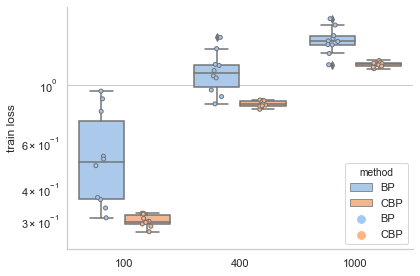

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x='batchsize', y='train loss', hue='method', data=df_res[df_res.momentum==0.],
            palette='pastel')
sns.stripplot(x='batchsize', y='train loss', hue='method', data=df_res[df_res.momentum==0.], size=4,
              color='.3', ax=ax, dodge=True, palette="pastel", linewidth=1.)
sns.despine(ax=ax)
ax.set_xlabel('')
ax.set_yscale('log')
fig.tight_layout()
fig.savefig('results/cifar10/loss_S.png', dpi=300)
plt.show()

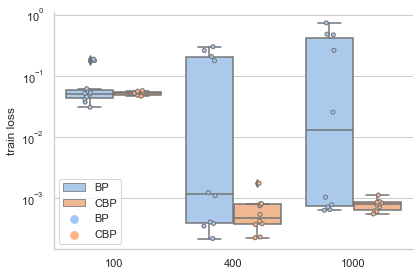

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x='batchsize', y='train loss', hue='method', data=df_res[df_res.momentum==0.9],
            palette='pastel')
sns.stripplot(x='batchsize', y='train loss', hue='method', data=df_res[df_res.momentum==0.9], size=4,
              color='.3', ax=ax, dodge=True, palette="pastel", linewidth=1.)
ax.legend(loc='lower left')
sns.despine(ax=ax)
ax.set_xlabel('')
ax.set_yscale('log')
fig.tight_layout()
fig.savefig('results/cifar10/loss_M.png', dpi=300)
plt.show()

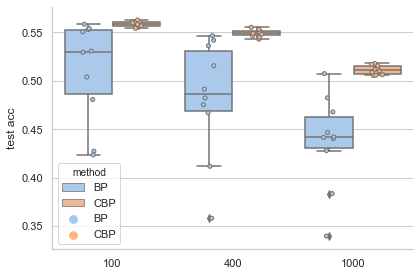

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x='batchsize', y='test acc', hue='method', data=df_res[df_res.momentum==0.],
            palette='pastel')
sns.stripplot(x='batchsize', y='test acc', hue='method', data=df_res[df_res.momentum==0.], size=4,
              color='.3', ax=ax, dodge=True, palette="pastel", linewidth=1.)
sns.despine(ax=ax)
ax.set_xlabel('')
fig.tight_layout()
fig.savefig('results/cifar10/acc_S.png', dpi=300)
plt.show()

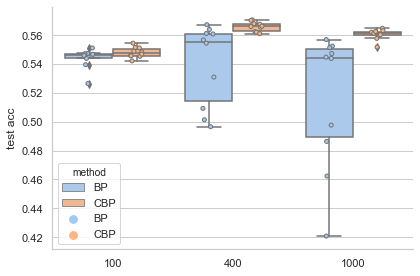

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x='batchsize', y='test acc', hue='method', data=df_res[df_res.momentum==0.9],
            palette='pastel')
sns.stripplot(x='batchsize', y='test acc', hue='method', data=df_res[df_res.momentum==0.9], size=4,
              color='.3', ax=ax, dodge=True, palette="pastel", linewidth=1.)
sns.despine(ax=ax)
ax.set_xlabel('')
fig.tight_layout()
fig.savefig('results/cifar10/acc_M.png', dpi=300)
plt.show()

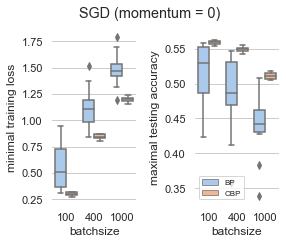

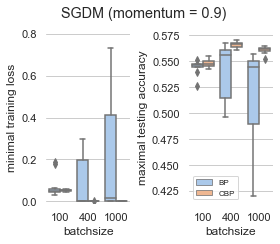

In [16]:
for momentum in [0, 0.9]:
    if momentum > 0:
        loss_lim = [-0.01, 0.81]
        opt_str = 'SGDM'
    else:
        loss_lim = [0.21, 1.84]
        opt_str = 'SGD'
    fig, ax = plt.subplots(1, 2, figsize=(4.5, 3.5))
    sns.boxplot(x='batchsize', y='train loss', hue='method', data=df_res[df_res.momentum==momentum],
                palette='pastel', ax=ax[0])
#     sns.stripplot(x='batchsize', y='train loss', hue='method', data=df_res[df_res.momentum==momentum], size=4,
#                   color='.3', ax=ax[0], dodge=True, palette="pastel", linewidth=1.)
    sns.boxplot(x='batchsize', y='test acc', hue='method', data=df_res[df_res.momentum==momentum],
                palette='pastel', ax=ax[1])
#     sns.stripplot(x='batchsize', y='test acc', hue='method', data=df_res[df_res.momentum==momentum], size=4,
#                   color='.3', ax=ax[1], dodge=True, palette="pastel", linewidth=1.)
    for a in ax:
        sns.despine(ax=a, left=True, bottom=True)
    ax[0].get_legend().remove()
    ax[0].set_ylim(loss_lim)
    lg = ax[1].get_legend()
    lg = ax[1].legend(handles=lg.legendHandles[:2], labels=['BP', 'CBP'],
                      title='', fontsize=8)
    ylabels=['minimal training loss', 'maximal testing accuracy']
    for i in range(2):
        ax[i].set_ylabel(ylabels[i])
    fig.suptitle(f'{opt_str} (momentum = {momentum})')
    fig.subplots_adjust(wspace=0.7, bottom=0.2, left=0.2)
    fig.savefig(f'results/cifar10/batch_{opt_str}.png', dpi=300)
    plt.show()

In [17]:
from scipy.stats import ttest_ind

pv = []
for batch_size in [100, 400, 1000]:
    for metric in ['train loss', 'test acc']:
        for momentum in [0., 0.9]:
            acc1=df_res[(df_res.momentum==momentum)&(df_res.batchsize==batch_size)&(df_res.method=='BP')].loc[:, metric]
            acc2=df_res[(df_res.momentum==momentum)&(df_res.batchsize==batch_size)&(df_res.method=='CBP')].loc[:, metric]
            pv.append([batch_size, metric, momentum, ttest_ind(acc1, acc2)[1] / 2])
pv_df = pd.DataFrame(pv, columns=['batchsize', 'metric', 'momentum', 'p-value'])
pv_df.to_csv('results/cifar10/pvalue.txt', index=False)

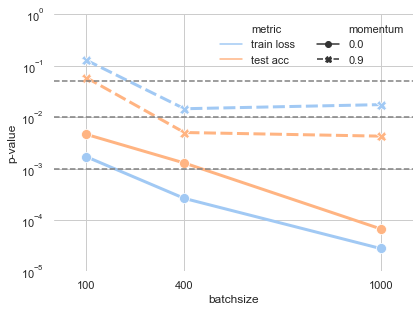

In [18]:
pv_df = pd.read_csv('results/cifar10/pvalue.txt')

fig, ax = plt.subplots(figsize=(6, 4.5))
sns.lineplot(x='batchsize', y='p-value', hue='metric', style='momentum', data=pv_df,
             palette='pastel', markers=True, lw=3, markersize=10)
ax.set_yscale('log')
for p in [0.05, 0.01, 0.001]:
    ax.axhline(y=p, c='grey', alpha=1, ls='--')
sns.despine(left=True, bottom=True)
ax.legend(frameon=False, ncol=2)
ax.set_xticks([100, 400, 1000])
ax.set_xlim(0, 1100)
ax.set_ylim(1e-5, 1.01)
plt.tight_layout()
fig.savefig('results/cifar10/pvalue.png', dpi=300)
plt.show()

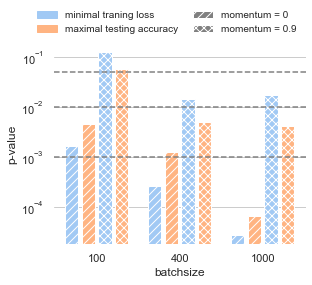

In [19]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(5, 4))
cs = sns.color_palette('pastel')
c1_patch = mpatches.Patch(color=cs[0], label='minimal traning loss')
c2_patch = mpatches.Patch(color=cs[1], label='maximal testing accuracy')
hatchs = ['///', 'xxx']
bar1 = ax.bar([0, 5, 10], pv_df[(pv_df.loc[:, 'metric']=='train loss') & (pv_df.loc[:, 'momentum']==0)].loc[:, 'p-value'],
              color=cs[0], hatch=hatchs[0])
bar2 = ax.bar([1, 6, 11], pv_df[(pv_df.loc[:, 'metric']=='test acc') & (pv_df.loc[:, 'momentum']==0)].loc[:, 'p-value'],
              color=cs[1], hatch=hatchs[0])
bar3 = ax.bar([2, 7, 12], pv_df[(pv_df.loc[:, 'metric']=='train loss') & (pv_df.loc[:, 'momentum']==0.9)].loc[:, 'p-value'],
              color=cs[0], hatch=hatchs[1])
bar4 = ax.bar([3, 8, 13], pv_df[(pv_df.loc[:, 'metric']=='test acc') & (pv_df.loc[:, 'momentum']==0.9)].loc[:, 'p-value'],
              color=cs[1], hatch=hatchs[1])
tmp_bar1 = ax.bar([0, 5, 10], [0]*3, color='grey', hatch=hatchs[0])
tmp_bar2 = ax.bar([0, 5, 10], [0]*3, color='grey', hatch=hatchs[1])
ax.set_yscale('log')
fig.subplots_adjust(top=0.85, bottom=0.15, left=0.2)
l1 =  ax.legend(handles=[c1_patch, c2_patch], bbox_to_anchor=[-0.1, 1, 0.5, 0.2],
                frameon=False, loc='lower left', fontsize=10)
ax.add_artist(l1)
l2 = ax.legend(handles=[tmp_bar1, tmp_bar2], labels=['momentum = 0', 'momentum = 0.9'],
               bbox_to_anchor=[0.5, 1, 0.5, 0.2], frameon=False, loc='lower right', fontsize=10)
ax.set_xticks([1.5, 6.5, 11.5])
ax.set_xticklabels([100, 400, 1000])
ax.set_xlabel('batchsize')
ax.set_ylabel('p-value')
for p in [0.05, 0.01, 0.001]:
    ax.axhline(y=p, c='grey', alpha=1, ls='--')
ax.grid(False, axis='x')
sns.despine(left=True, bottom=True)
fig.savefig('results/cifar10/pvalue_barplot.png', dpi=300)
plt.show()